# Introduction

This is an exercise to learn more about time series prediction using LSTM RNNs. The [dataset](https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#) runs from 1949 to 1960 and has a monthly total number of international passengers for each month in that time period. The problem to solve is, given a month and year, to predict the number of passengers that will fly internationally in that time period. (Passenger numbers are given in thousands)

Long Short-Term Memory nodes augment the output of a standard neural network node by adding a 

This work is adapted from http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

First, let's load up the raw data and plot it:

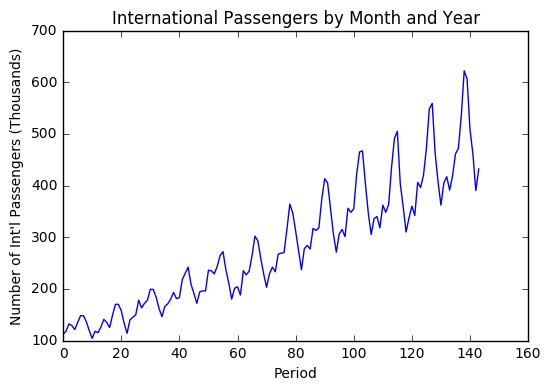

In [113]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# fix random seed for reproducibility
numpy.random.seed(43)

# load the data
dataframe = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# plot the raw data
plt.title("International Passengers by Month and Year")
plt.xlabel("Period")
plt.ylabel("Number of Int'l Passengers (Thousands)")

plt.plot(dataset)
plt.show()

We can see a couple of things from the plot:
1. There is a peak in international travel around the same period every year
2. There is a general upward trend indicating that the demand for travel is continually increasing over this time period

# Activation Functions & Learning

When designing a neural network with sigmoid or tanh activation functions in any layer, it's important to keep in mind how these activations affect both the forward and backward passes through the layers. 

Looking at the plot of the sigmoid function below, we see that any value less than about -5.0 will evaluate to approximately zero and any value greater than about 5.0 will evaluate to 1. So if we have initial values from our examples that are large or initial weights that are large, we'll essentially force the output of the layer's activations to produce a nearly binary (0 or 1) vector of output values. Clearly, it's important to keep the initial values from our training examples within a certain range centered around zero, and we can accomplish that through normalizing the dataset.

When the forward pass is done and it's time to run backprop to change the parameters in the network, we evaluate the gradient of the sigmoid activation (z * (1-z)). Again, if we've produced a binary output vector from the forward pass, the gradient will be zero or close to zero and the remainder of the backward pass will produce parameter update values near zero, resulting in no change to the network parameters and effectively stopping the network from learning.

It's a similar story for the tanh activation function, so consider yourself warned! For further reading, consider Yann LeCun et al's [classic "Efficient BackProp" paper](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf).

LSTM networks aren't as susceptible to the vanishing gradient problem on account of their ability to store and recall previous values. Even so, they are sensitive to the scale of the input values.

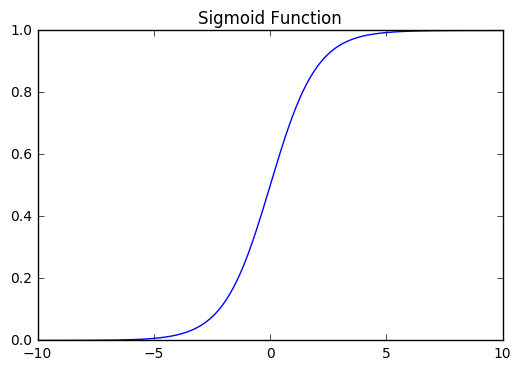

In [114]:
def sigmoid(t):
    return (1 / (1 + numpy.exp(-t)))

t = numpy.arange(-10, 10, 0.01)

plt.title("Sigmoid Function")
plt.plot(t,sigmoid(t))
plt.show()

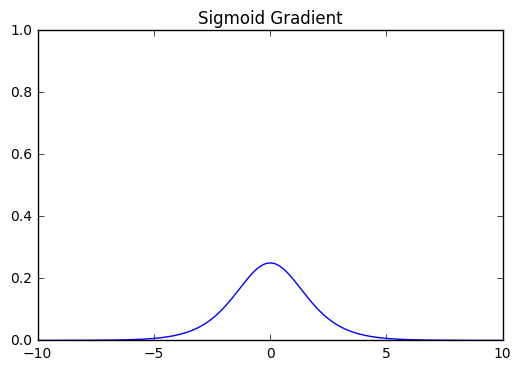

In [115]:
def sigmoid_gradient(t):
    return sigmoid(t) * (1-sigmoid(t))

plt.title("Sigmoid Gradient")
plt.ylim(0,1)
plt.plot(t, sigmoid_gradient(t))
plt.show()

# Normalize Data

Now that we understand the importantance of normalizing our dataset before we feed it into a LSTM neural network, it's easy to do so thanks to sklearn.preprocessing:

In [116]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Create Training and Test Sets

If we restructure the data, we can approach this challenge as a regression problem where we're trying to solve what next month's number of passengers is based on the current month's number. So we create two columns: the first is the current month's number of passengers and the second the following month's number of passengers. The create_dataset function converts the dataset from an array of values to a matrix with the two columns described above.

In [117]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [118]:
# convert an array of values into a dataset matrix
# look_back parameter is the number of previous timesteps to use as input to predict the next time period
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX and testX now both contian data in the format [samples, features] and the LSTM network expects to have data in a slightly different format of [samples, time steps, features]. Since we chose look_back to equal 1, the time steps value will always be 1, and we can add that to the X sets.

In [119]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Design and Fit the LSTM Network

The network consists of an input layer with one node, a hidden LSTM layer with 20 nodes (arbitrarily chosen number > 12 periods to capture annual trends), and a single output node to make the prediction for the next time period.

In [120]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(20, input_dim=look_back))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0268
Epoch 2/100
0s - loss: 0.0129
Epoch 3/100
0s - loss: 0.0110
Epoch 4/100
0s - loss: 0.0093
Epoch 5/100
0s - loss: 0.0074
Epoch 6/100
0s - loss: 0.0060
Epoch 7/100
0s - loss: 0.0048
Epoch 8/100
0s - loss: 0.0039
Epoch 9/100
0s - loss: 0.0030
Epoch 10/100
0s - loss: 0.0027
Epoch 11/100
0s - loss: 0.0024
Epoch 12/100
0s - loss: 0.0022
Epoch 13/100
0s - loss: 0.0022
Epoch 14/100
0s - loss: 0.0022
Epoch 15/100
0s - loss: 0.0020
Epoch 16/100
0s - loss: 0.0022
Epoch 17/100
0s - loss: 0.0022
Epoch 18/100
0s - loss: 0.0021
Epoch 19/100
0s - loss: 0.0021
Epoch 20/100
0s - loss: 0.0021
Epoch 21/100
0s - loss: 0.0022
Epoch 22/100
0s - loss: 0.0021
Epoch 23/100
0s - loss: 0.0020
Epoch 24/100
0s - loss: 0.0020
Epoch 25/100
0s - loss: 0.0021
Epoch 26/100
0s - loss: 0.0021
Epoch 27/100
0s - loss: 0.0021
Epoch 28/100
0s - loss: 0.0021
Epoch 29/100
0s - loss: 0.0021
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0021
Epoch 32/100
0s - loss: 0.0021
Epoch 33/100
0s -

In [121]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions to get the results in the same units as the original dataset
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.42 RMSE
Test Score: 50.46 RMSE


For a relatively simple network and a small training set, this is a surprisingly good result. The training error is around 23,000 passengers/month and the test error is 50,000 passengers per month.

Now we need to massage the results a bit to get them to match the x-axis of the original dataset.

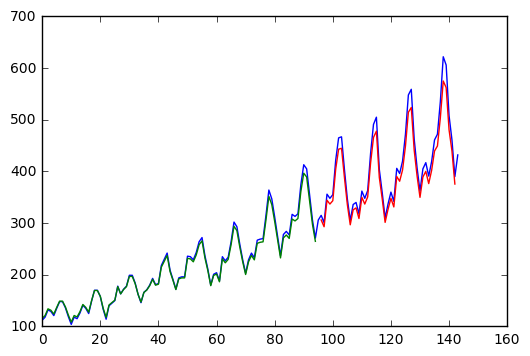

In [122]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[0:len(trainPredict), :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+look_back:len(dataset)-look_back, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In the plot above, the blue line is the original dataset. The green plot is that of the training data. The red plot is the test data and it's surprising to see how close the predictions are to the actual data even with such a limited amount of training data (96 data points). Perhaps if there was more training data, the predictions over the test set would be even more accurate.

Also interesting is that the LSTM learned the periodic nature of the peaks and dips of travel demand based on the training set. It seems as though there may be a longer timespan trend such as an up business cycle that is increasing demand in the latter years that could help the model better predict annual growth (or decline) if the dataset spanned a much longer period. 